In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize, Bounds, LinearConstraint

## Analytique

Lambda (lambda_theta[0]) : -0.0005687194500344881
Theta (lambda_theta[1]) : 0.7587319337903184
Poids optimaux du portefeuille : [ 1.52776716  3.08463871  6.28167588 -1.86560433 -8.02847742]


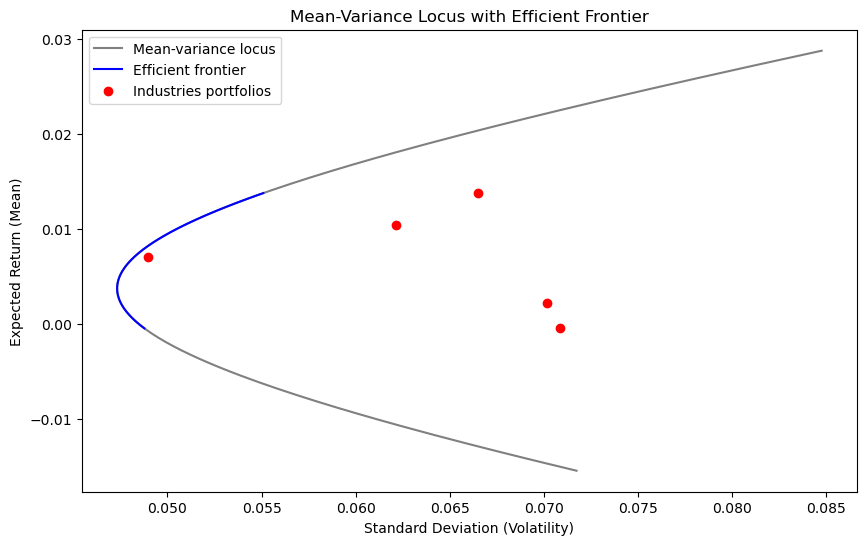

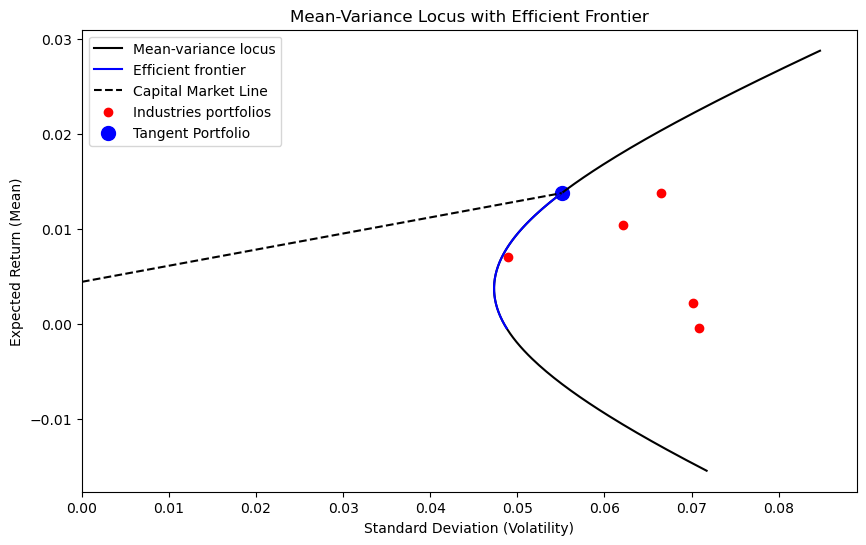

In [7]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/Markowitz/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1109:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

# Number of bootstrap samples you want to generate
num_bootstrap_samples = 1

# Perform bootstrap sampling
bootstrap_samples = [df_5.sample(n=len(df_5), replace=True) for _ in range(num_bootstrap_samples)]

# Now bootstrap_samples is a list of DataFrames, each containing rows sampled with replacement from the original DataFrame.

# Concatenate the list of DataFrames into a single DataFrame
bootstrap_df = pd.concat(bootstrap_samples)

# Reset the index if needed
bootstrap_df.reset_index(drop=True, inplace=True)

bootstrap_df = bootstrap_df.values / 100

sigma_boot = np.cov(bootstrap_df, rowvar=False)

z_barre = np.mean(bootstrap_df, axis=0)
Z_barre = z_barre  # Rendements espérés des actifs
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

# Inversion de la matrice de covariance
Sigma_inv = np.linalg.inv(sigma_boot)

# Construction de la matrice A et du vecteur b
A = np.array([
    [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
    [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
])
b = np.array([1, R_cible])

# Inversion de la matrice A
A_inv = np.linalg.inv(A)

# Résolution pour obtenir les multiplicateurs de Lagrange
lambda_theta = np.dot(A_inv, b)

# Calcul des poids optimaux du portefeuille
w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

print("Lambda (lambda_theta[0]) :", lambda_theta[0])
print("Theta (lambda_theta[1]) :", lambda_theta[1])
print("Poids optimaux du portefeuille :", w_optimal)

# Intervalle des rendements cibles pour la frontière efficiente
rendements_cibles_efficients = np.linspace(min(Z_barre), max(Z_barre), 100)

# Calcul des volatilités et des rendements pour la frontière efficiente
volatilites_optimales = []
rendements_optimaux = []

for R_cible in rendements_cibles_efficients:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(wi_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_boot, wi_optimal)))
    rendements_optimaux.append(rendement_optimal)
    volatilites_optimales.append(volatilite_optimale)

# Étendre l'intervalle des rendements cibles pour la frontière complète
rendements_cibles_etendus = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 200)

# Calcul des volatilités et des rendements pour la frontière complète
volatilites_optimales_etendues = []
rendements_optimaux_etendus = []
for R_cible in rendements_cibles_etendus:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(wi_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_boot, wi_optimal)))
    rendements_optimaux_etendus.append(rendement_optimal)
    volatilites_optimales_etendues.append(volatilite_optimale)


# Risk-free rate (you need to define your risk-free rate)
rf = 0.0044

# Calculate the slope of the CML
CML_slope = (max(rendements_optimaux) - rf) / max(volatilites_optimales)

# Generate standard deviations for the CML
CML_std = np.linspace(0, max(volatilites_optimales), 100)

# Calculate corresponding expected returns for the CML
CML_ret = rf + CML_slope * CML_std

# Calculate Sharpe Ratios for all points on the efficient frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the return and volatility of the tangent portfolio
tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]

# Tracer la frontière complète et la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Mean-variance locus', color='grey')
plt.plot(volatilites_optimales, rendements_optimaux, label='Efficient frontier', color='blue')
plt.scatter(np.sqrt(np.diag(sigma_boot)), Z_barre, color='red', label='Industries portfolios')
plt.title('Mean-Variance Locus with Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
plt.show()

# Tracer la frontière complète et la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Mean-variance locus', color='black')
plt.plot(volatilites_optimales, rendements_optimaux, label='Efficient frontier', color='blue')
plt.plot(CML_std, CML_ret, label='Capital Market Line', color='black', linestyle='--')
plt.scatter(np.sqrt(np.diag(sigma_boot)), Z_barre, color='red', label='Industries portfolios')
plt.scatter(tangent_portfolio_volatility, tangent_portfolio_return, color='blue', marker='o', s=100, label='Tangent Portfolio')
plt.title('Mean-Variance Locus with Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
plt.xlim(0)
plt.show()


In [3]:
# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the weights of the tangent portfolio
tangent_portfolio_weights = wi_optimal 

# Calculate the mean (expected return) of the tangent portfolio
tangent_portfolio_mean = rendements_optimaux[max_sharpe_index]

# Calculate the variance of the tangent portfolio
tangent_portfolio_variance = volatilites_optimales[max_sharpe_index] ** 2

# Print or use these values as needed
print("Tangent Portfolio Mean:", tangent_portfolio_mean)
print("Tangent Portfolio Variance:", tangent_portfolio_variance)
print("Tangent Portfolio Weights:", tangent_portfolio_weights)

Tangent Portfolio Mean: 0.010009999999999996
Tangent Portfolio Variance: 0.003250759138133674
Tangent Portfolio Weights: [-1.50067132  2.05327697  2.79481331 -0.72178016 -1.6256388 ]


## Numérique

In [4]:
# Step 2: Perform bootstrap sampling
bootstrap_sample = df_5.sample(n=60, replace=True)  # Bootstrap sample of 60 rows with replacement

# Step 3: Use the sampled dataframe in your existing code
ret_5 = bootstrap_sample.values / 100
var_5 = np.var(ret_5, axis=0, keepdims=True)
std_5 = np.sqrt(np.var(ret_5, axis=0, keepdims=True))

# Calculate the mean and covariance matrix
z_barre = np.mean(ret_5, axis=0)
Sigma_5 = np.cov(ret_5.T)

exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

# Fonction objectif : Variance du portefeuille
def minportfolio_variance(W,Sigma_5):
    return W.T @ (Sigma_5 @ W)

# Poids initiaux : répartition uniforme
W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

# Fonction d'optimisation
def optimize(func, W, Sigma_5, target_return):

    # Contraintes
    opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                       {'type': 'eq', 'fun': lambda W: W.T @ z_barre - target_return},  # Le rendement attendu doit être égal au rendement cible
                       {'type': 'ineq', 'fun': lambda W: W})  # No short selling constraint

    # Optimisation
    optimal_weights = minimize(func, W, args=( Sigma_5), method='trust-constr', constraints=opt_constraints)

    return optimal_weights.x

# Appel de la fonction d'optimisation
optimal_weights = optimize(minportfolio_variance, W, Sigma_5, R_cible)

print("Poids optimaux du portefeuille :", optimal_weights)

# Générer une série de rendements cibles
rendements_cibles = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 100)

# Initialiser les listes pour stocker les volatilités et rendements optimaux
volatilites_optimales = []
rendements_optimaux = []

# Itérer sur les rendements cibles pour optimiser les poids du portefeuille
for R_cible in rendements_cibles:
    W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))  # Réinitialiser les poids initiaux pour chaque itération
    poids_optimaux = optimize(minportfolio_variance, W, Sigma_5, R_cible)
    var_optimale = minportfolio_variance(poids_optimaux, Sigma_5)
    rendement_optimal = np.dot(poids_optimaux, Z_barre)

    volatilites_optimales.append(np.sqrt(var_optimale))
    rendements_optimaux.append(rendement_optimal)

# Calculate the CML equation
CML_returns = np.linspace(rf, max(rendements_optimaux), 100)
CML_volatilities = (CML_returns - rf) / ((max(rendements_optimaux) - rf) / max(volatilites_optimales))

# Calculate Sharpe Ratios for all points on the efficient frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the return and volatility of the tangent portfolio
tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]

/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


Poids optimaux du portefeuille : [-7.40838741e-04 -7.23764962e-04  1.00513956e+00 -1.04255368e-03
 -5.45893456e-04]


(0.0, 0.06584226788735807)

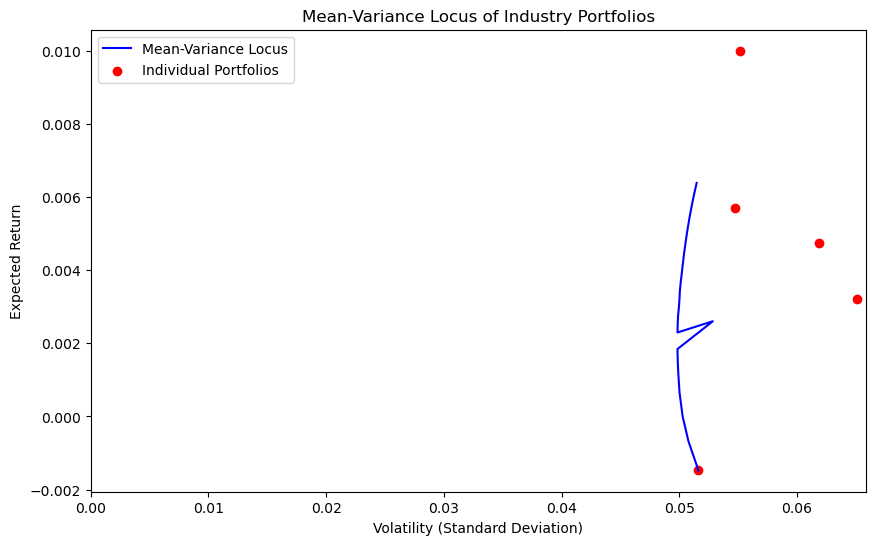

In [5]:
# Tracer la frontière de variance moyenne
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Mean-Variance Locus')
plt.scatter(np.sqrt(np.diag(Sigma_5)), Z_barre, color='red', label='Individual Portfolios')
plt.title('Mean-Variance Locus of Industry Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.xlim(0)

(0.0, 0.06833453183618941)

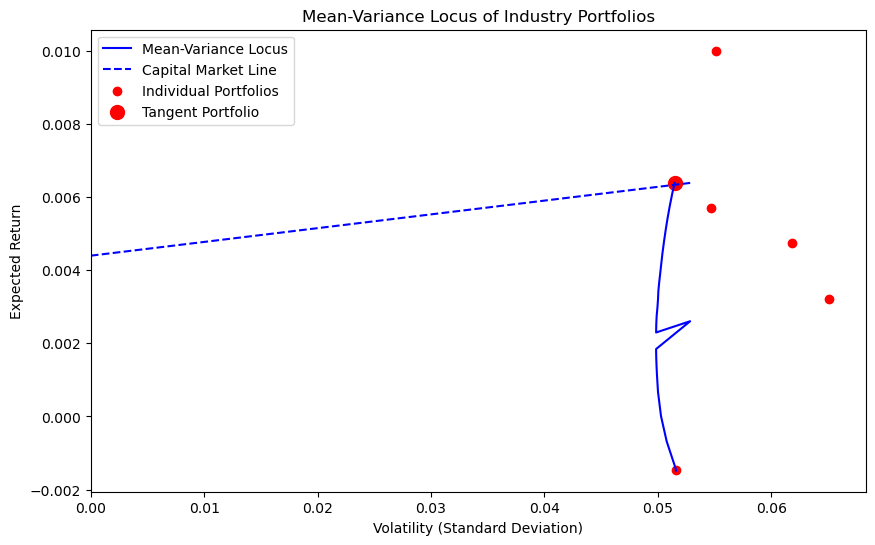

In [6]:
# Tracer la frontière de variance moyenne
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Mean-Variance Locus')
plt.plot(CML_volatilities, CML_returns, 'b--', label='Capital Market Line')
plt.scatter(np.sqrt(np.diag(Sigma_5)), Z_barre, color='red', label='Individual Portfolios')
plt.scatter(volatilites_optimales[99], tangent_portfolio_return, color='red', marker='o', s=100, label='Tangent Portfolio')
plt.title('Mean-Variance Locus of Industry Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.xlim(0)

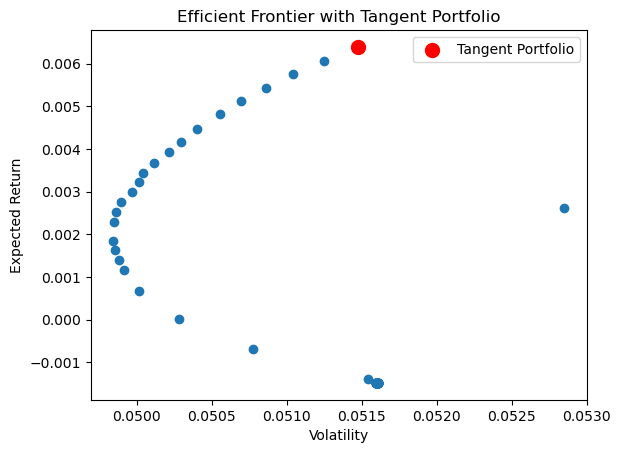

In [7]:
# Plot the efficient frontier
plt.scatter(volatilites_optimales, rendements_optimaux, marker='o', linestyle='-')

# Plot the tangent portfolio point
plt.scatter(tangent_portfolio_volatility, tangent_portfolio_return, color='red', marker='o', s=100, label='Tangent Portfolio')

# Add labels and title
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Tangent Portfolio')
plt.legend()

# Show the plot
plt.show()
